In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
class Model:
  def __init__(self, name, input_dim, output_dim, hidden_dims = [32, 32], use_batchnorm = True, activation_fn = tf.nn.relu, optimizer = tf.train.AdamOptimizer, lr = 0.01):
    with tf.variable_scope(name):
      # Placeholders are defined
      self.X = tf.placeholder(tf.float32, [None, input_dim], name = 'X')
      self.y = tf.placeholder(tf.float32, [None, output_dim], name = 'y')
      self.mode = tf.placeholder(tf.bool, name = 'train_mode')

      # Loop over hidden layers
      net = self.X
      for i, h_dim in enumerate(hidden_dims):
        with tf.variable_scope('layer{}'.format(i)):
          net = tf.layers.dense(net, h_dim)

          if use_batchnorm:
            net = tf.layers.batch_normalization(net, training = self.mode)
          
          net = activation_fn(net)
      
      # Attach fully connected layers
      net = tf.contrib.layers.flatten(net)
      net = tf.layers.dense(net, output_dim)

      self.loss = tf.nn.softmax_cross_entropy_with_logits(logits = net, labels = self.y)
      self.loss = tf.reduce_mean(self.loss, name = 'loss')

      # When using the batchnormalization layers,
      # it is necessary to manually add the update operations
      # because the moving averages are not included in the graph
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = name)
      with tf.control_dependencies(update_ops):
        self.train_op = optimizer(lr).minimize(self.loss)
      
      # Accuracy etc
      softmax = tf.nn.softmax(net, name = 'softmax')
      self.accuracy = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
      self.accuracy = tf.reduce_mean(tf.cast(self.accuracy, tf.float32))

In [6]:
class Solver:
  def __init__(self, sess, model):
    self.model = model
    self.sess = sess
  
  def train(self, X, y):
    feed = {
        self.model.X: X,
        self.model.y: y,
        self.model.mode: True
    }
    train_op = self.model.train_op
    loss = self.model.loss

    return self.sess.run([train_op, loss], feed_dict = feed)
  
  def evaluate(self, X, y, batch_size = None):
    if batch_size:
      N = X.shape[0]

      total_loss = 0
      total_acc = 0

      for i in range(0, N, batch_size):
        X_batch = X[i: i + batch_size]
        y_batch = y[i: i + batch_size]

        feed = {
            self.model.X: X_batch,
            self.model.y: y_batch,
            self.model.mode: False
        }

        loss = self.model.loss
        accuracy = self.model.accuracy

        step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict = feed)

        total_loss += step_loss * X_batch.shape[0]
        total_acc += step_acc * X_batch.shape[0]
      
      total_loss /= N
      total_acc /= N

      return total_loss, total_acc
    
    else:
      feed = {
          self.model.X: X,
          self.model.y: y,
          self.model.mode: False
      }

      loss = self.model.loss
      accuracy = self.model.accuracy

      return self.sess.run([loss, accuracy], feed_dict = feed)

In [7]:
input_dim = 784
output_dim = 10
N = 55000

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
# We create two models: one with the batch norm and other without
bn = Model('batchnorm', input_dim, output_dim, use_batchnorm = True)
nn = Model('no_norm', input_dim, output_dim, use_batchnorm = False)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
# We create two solvers: to train both models at the same time for comparison
# Usually we only need one solver class
bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)

In [11]:
epoch_n = 10
batch_size = 32

In [12]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

In [13]:
valid_losses = []
valid_accs = []

In [14]:
init = tf.global_variables_initializer()
sess.run(init)

In [15]:
for epoch in range(epoch_n):
  for _ in range(N // batch_size):
    X_batch, y_batch = mnist.train.next_batch(batch_size)

    _, bn_loss = bn_solver.train(X_batch, y_batch)
    _, nn_loss = nn_solver.train(X_batch, y_batch)
  
  b_loss, b_acc = bn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
  n_loss, n_acc = nn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)

  # Save train losses/acc
  train_losses.append([b_loss, n_loss])
  train_accs.append([b_acc, n_acc])
  print(f'[Epoch {epoch}-TRAIN] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')

  b_loss, b_acc = bn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
  n_loss, n_acc = nn_solver.evaluate(mnist.validation.images, mnist.validation.labels)

  # Save valid losses/acc
  valid_losses.append([b_loss, n_loss])
  valid_accs.append([b_acc, n_acc])
  print(f'[Epoch {epoch}-VALID] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
  print()

[Epoch 0-TRAIN] Batchnorm Loss(Acc): 0.16552(95.07%) vs No Batchnorm Loss(Acc): 0.19851(94.05%)
[Epoch 0-VALID] Batchnorm Loss(Acc): 0.17501(94.64%) vs No Batchnorm Loss(Acc): 0.19771(94.30%)

[Epoch 1-TRAIN] Batchnorm Loss(Acc): 0.10583(96.74%) vs No Batchnorm Loss(Acc): 0.14910(95.71%)
[Epoch 1-VALID] Batchnorm Loss(Acc): 0.11538(96.68%) vs No Batchnorm Loss(Acc): 0.16718(95.24%)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): 0.09204(97.15%) vs No Batchnorm Loss(Acc): 0.17263(94.88%)
[Epoch 2-VALID] Batchnorm Loss(Acc): 0.11086(96.64%) vs No Batchnorm Loss(Acc): 0.18862(94.60%)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): 0.08221(97.41%) vs No Batchnorm Loss(Acc): 0.15914(95.37%)
[Epoch 3-VALID] Batchnorm Loss(Acc): 0.11215(96.98%) vs No Batchnorm Loss(Acc): 0.19740(94.98%)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): 0.09174(96.99%) vs No Batchnorm Loss(Acc): 0.14864(95.85%)
[Epoch 4-VALID] Batchnorm Loss(Acc): 0.11773(96.44%) vs No Batchnorm Loss(Acc): 0.18987(95.46%)

[Epoch 5-TRAIN] Batchnorm Loss(Acc)

In [16]:
bn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.10530027, 0.9698]

In [17]:
nn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.21064329, 0.9528]

In [18]:
def plot_compare(loss_list: list, ylim = None, title = None) -> None:

  bn = [i[0] for i in loss_list]
  nn = [i[1] for i in loss_list]

  plt.figure(figsize = (15, 10))
  plt.plot(bn, label = 'With BN')
  plt.plot(nn, label = 'Without BN')
  if ylim:
    plt.ylim(ylim)
  
  if title:
    plt.title(title)
  plt.legend()
  plt.grid('on')
  plt.show()

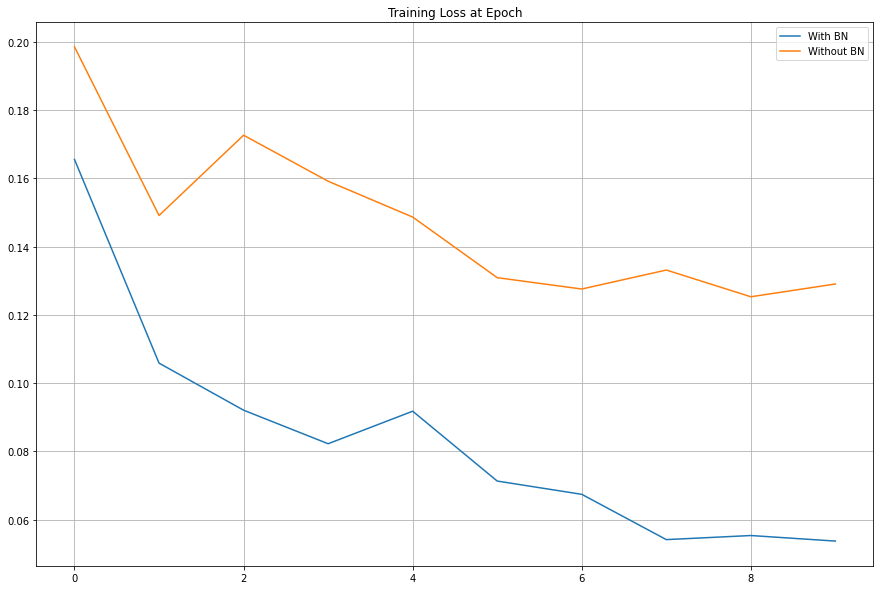

In [19]:
plot_compare(train_losses, title='Training Loss at Epoch')

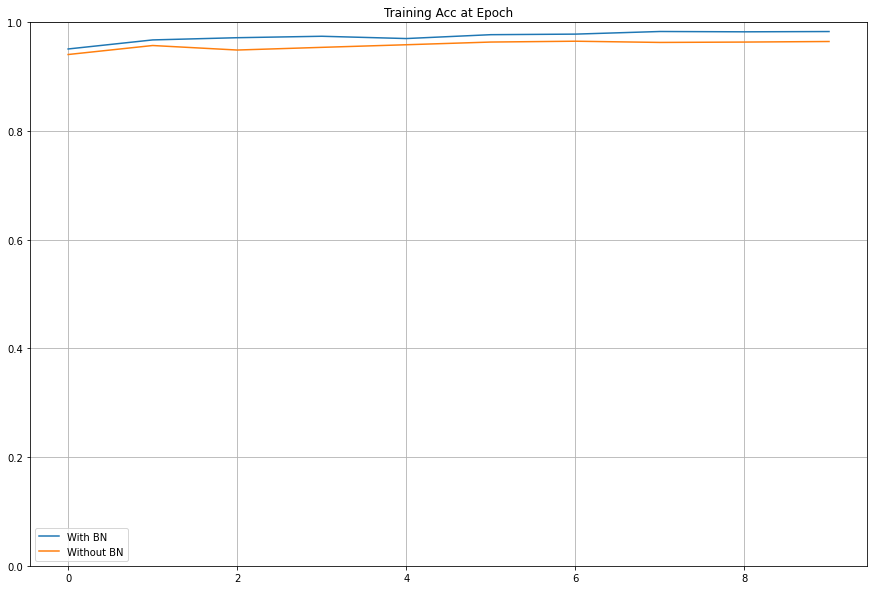

In [20]:
plot_compare(train_accs, [0, 1.0], title = "Training Acc at Epoch")

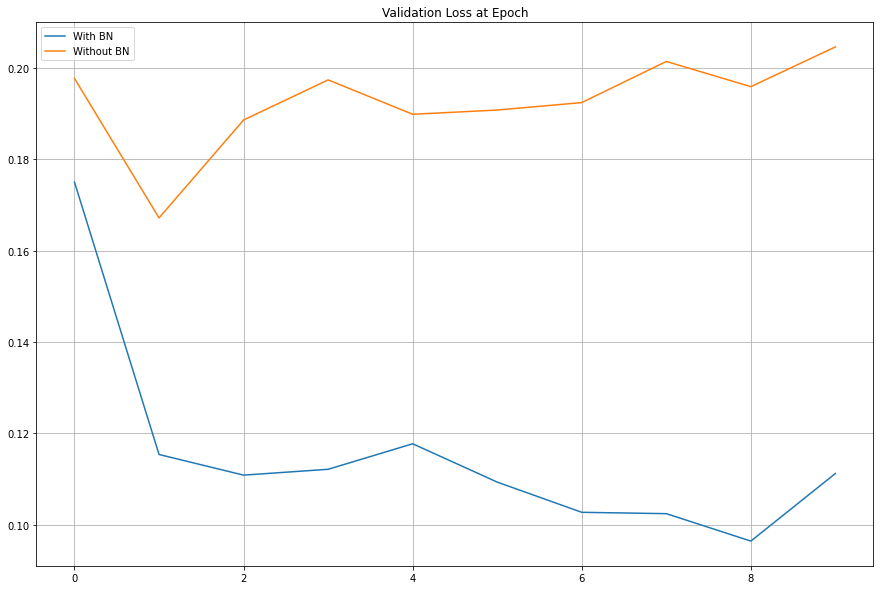

In [21]:
plot_compare(valid_losses, title = 'Validation Loss at Epoch')

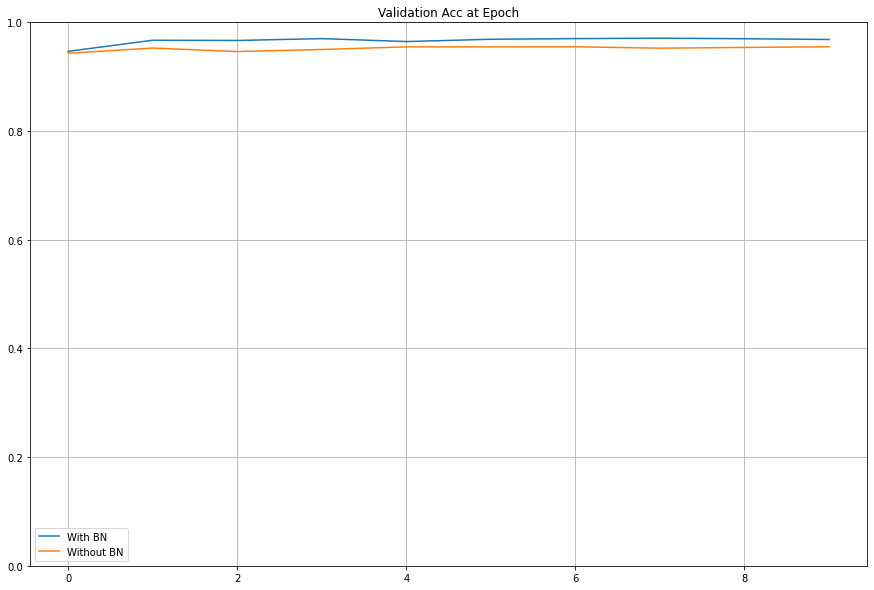

In [22]:
plot_compare(valid_accs, [0, 1.], title = 'Validation Acc at Epoch')